In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-PreSpA-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Presynoviomics-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-Block-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20240514-DataSheet-RUN55.csv"
run = "run55"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run55-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BB5072-T2_S118,ACTGACTG,CSVEEGGYTEAFFG,3186,417,TRBV29-1,TRBJ1-1,6347,1.992153,0.729828,0.524865
1,BB5072-T2_S118,ACTGACTG,CSVEEGGNQPQHFG,2068,262,TRBV29-1,TRBJ1-5,4118,1.991296,0.473724,0.329771
2,BB5072-T2_S118,ACTGACTG,CSVATGEWGYTFG,1446,174,TRBV29-1,TRBJ1-2,2853,1.973029,0.331240,0.219008
3,BB5072-T2_S118,ACTGACTG,CASSFG,973,159,TRBV12-3+TRBV12-4+TRBV27+TRBV5-1+TRBV5-4+TRBV5-6,"TRBJ2-3,TRBJ1-5,TRBJ2-7,TRBJ1-1,TRBJ1-2,TRBJ2-...",795,0.817061,0.222889,0.200128
4,BB5072-T2_S118,ACTGACTG,CSLSQARICEQYFG,715,99,TRBV29-1,"TRBJ2-7,TRBJ2-5",1468,2.053147,0.163788,0.124608


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,MID,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
2676617,pSpA-180-T2_S101,CATSIYGGNEQFFG,CGATCGAT,1154,125,TRBV15,TRBJ2-1,1153,0.999133,0.254630,0.197086
2680960,pSpA-180-T2_S101,CSVVGRQPVTDTQYFG,CGATCGAT,901,95,TRBV29-1,TRBJ2-3,1801,1.998890,0.198805,0.149786
2661317,pSpA-180-T2_S101,CASSFG,CGATCGAT,900,143,TRBV12-3+TRBV13+TRBV27+TRBV5-5+TRBV5-6+TRBV6-5...,"TRBJ2-5,TRBJ1-5,TRBJ2-7,TRBJ1-1,TRBJ2-1,TRBJ1-...",735,0.816667,0.198585,0.225467
2665811,pSpA-180-T2_S101,CASSLRGSGYNEQFFG,CGATCGAT,568,78,TRBV12-3+TRBV12-4,TRBJ2-1,567,0.998239,0.125329,0.122982
2680400,pSpA-180-T2_S101,CSVGTGGTNEKLFFG,CGATCGAT,540,53,TRBV29-1,TRBJ1-4,1074,1.988889,0.119151,0.083565


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,RACE,Group,HEK_cells,Constant,MID
0,N701_S502,BP2338-pre-T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,...,human,TCRb,BP2338,pre-sort,yes,no,NaN,no,no,NaN
1,N702_S502,BP2880-pre-T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,...,human,TCRb,BP2880,pre-sort,yes,no,NaN,no,no,NaN
2,N705_S502,BP2880-CD4pTc-T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,...,human,TCRb,BP2880,CD4+ T cells,yes,no,NaN,no,no,NaN
3,N711_S502,pSpA-004-T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,...,human,TCRb,1123034,V4,yes,no,NaN,no,no,NaN
4,N712_S502,pSpA-010-T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,...,human,TCRb,1123006,V4,yes,no,NaN,no,no,NaN


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,BP2338-pre-T_S1,BP2338
1,BP2880-pre-T_S2,BP2880
2,BP2880-CD4pTc-T_S3,BP2880
3,pSpA-004-T2_S4,1123034
4,pSpA-010-T2_S5,1123006


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,MID,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,pSpA-180-T2_S101,CATSIYGGNEQFFG,CGATCGAT,1154,125,TRBV15,TRBJ2-1,1153,0.999133,0.254630,0.197086,SPA010310
1,pSpA-180-T2_S101,CSVVGRQPVTDTQYFG,CGATCGAT,901,95,TRBV29-1,TRBJ2-3,1801,1.998890,0.198805,0.149786,SPA010310
2,pSpA-180-T2_S101,CASSFG,CGATCGAT,900,143,TRBV12-3+TRBV13+TRBV27+TRBV5-5+TRBV5-6+TRBV6-5...,"TRBJ2-5,TRBJ1-5,TRBJ2-7,TRBJ1-1,TRBJ2-1,TRBJ1-...",735,0.816667,0.198585,0.225467,SPA010310
3,pSpA-180-T2_S101,CASSLRGSGYNEQFFG,CGATCGAT,568,78,TRBV12-3+TRBV12-4,TRBJ2-1,567,0.998239,0.125329,0.122982,SPA010310
4,pSpA-180-T2_S101,CSVGTGGTNEKLFFG,CGATCGAT,540,53,TRBV29-1,TRBJ1-4,1074,1.988889,0.119151,0.083565,SPA010310


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                 10040         1123001        1123003                  \
Sample         BB5072-T2_S118 pSpA-048-T2_S22 pSpA-027-T2_S9 pSpA-037-T2_S19   
cdr3pep                                                                        
CAAAADNTIYFG              0.0             0.0            0.0             0.0   
CAAAADSTIYFG              0.0             0.0            0.0             0.0   
CAAAAGGADTQYFG            0.0             0.0            0.0             0.0   
CAAAAGRNQPQHFG            0.0             0.0            0.0             0.0   
CAAAAPGTQYFG              0.0             0.0            0.0             0.0   

Patient                1123005        1123006                        1123007  \
Sample         pSpA-040-T2_S20 pSpA-010-T2_S5 pSpA-028-T2_S10 pSpA-015-T2_S6   
cdr3pep                                                                        
CAAAADNTIYFG               0.0            0.0             0.0            0.0   
CAAAADSTIYFG               0.0            0.0             0.0            0.0   
CAAAAGGADTQYFG             0.0            0.0             0.0            0.0   
CAAAAGRNQPQHFG             0.0            0.0             0.0            0.0   
CAAAAPGTQYFG               0.0           25.0             0.0            0.0   

Patient                               1123015  ...      SPA010137  \
Sample         pSpA-020-T2_S7 pSpA-081-T2_S38  ... pSpA-167-T_S82   
cdr3pep                                        ...                  
CAAAADNTIYFG              0.0             0.0  ...            0.0   
CAAAADSTIYFG              0.0             0.0  ...            0.0   
CAAAAGGADTQYFG            0.0             0.0  ...            0.0   
CAAAAGRNQPQHFG            0.0             0.0  ...            0.0   
CAAAAPGTQYFG              0.0             0.0  ...            0.0   

Patient             SPA010199       SPA010255       SPA010265  \
Sample         pSpA-176-T_S88 pSpA-164-T2_S73 pSpA-139-T2_S70   
cdr3pep                                                         
CAAAADNTIYFG              0.0             0.0             0.0   
CAAAADSTIYFG              0.0             0.0             0.0   
CAAAAGGADTQYFG            0.0             0.0             0.0   
CAAAAGRNQPQHFG            0.0             0.0             0.0   
CAAAAPGTQYFG              0.0             0.0             0.0   

Patient               SPA010291       SPA010304       SPA010305  \
Sample         pSpA-179-T2_S100 pSpA-135-T2_S69 pSpA-150-T2_S72   
cdr3pep                                                           
CAAAADNTIYFG                0.0             0.0             0.0   
CAAAADSTIYFG                0.0             0.0             0.0   
CAAAAGGADTQYFG              0.0             0.0             0.0   
CAAAAGRNQPQHFG              0.0             0.0             0.0   
CAAAAPGTQYFG                0.0             0.0             0.0   

Patient               SPA010310      SPA010332       SPA010345  
Sample         pSpA-180-T2_S101 pSpA-178-T_S89 pSpA-141-T2_S71  
cdr3pep                                                         
CAAAADNTIYFG                0.0            0.0             0.0  
CAAAADSTIYFG                0.0            0.0             0.0  
CAAAAGGADTQYFG              0.0            0.0             0.0  
CAAAAGRNQPQHFG              0.0            0.0             0.0  
CAAAAPGTQYFG                0.0            0.0             0.0  

[5 rows x 156 columns]

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                          10040         1123001        1123003  \
Sample                  BB5072-T2_S118 pSpA-048-T2_S22 pSpA-027-T2_S9   
Patient Sample                                                          
10040   BB5072-T2_S118        1.000000        0.011956       0.010926   
1123001 pSpA-048-T2_S22       0.011956        1.000000       0.011956   
1123003 pSpA-027-T2_S9        0.010926        0.011956       1.000000   
        pSpA-037-T2_S19       0.008106        0.007812       0.088154   
1123005 pSpA-040-T2_S20       0.009778        0.042698       0.009302   

Patient                                         1123005        1123006  \
Sample                  pSpA-037-T2_S19 pSpA-040-T2_S20 pSpA-010-T2_S5   
Patient Sample                                                           
10040   BB5072-T2_S118         0.008106        0.009778       0.011118   
1123001 pSpA-048-T2_S22        0.007812        0.042698       0.012313   
1123003 pSpA-027-T2_S9         0.088154        0.009302       0.009359   
        pSpA-037-T2_S19        1.000000        0.006019       0.007493   
1123005 pSpA-040-T2_S20        0.006019        1.000000       0.011198   

Patient                                        1123007                 \
Sample                  pSpA-028-T2_S10 pSpA-015-T2_S6 pSpA-020-T2_S7   
Patient Sample                                                          
10040   BB5072-T2_S118         0.009409       0.008996       0.008929   
1123001 pSpA-048-T2_S22        0.009375       0.010827       0.008823   
1123003 pSpA-027-T2_S9         0.008381       0.010382       0.008640   
        pSpA-037-T2_S19        0.006570       0.006644       0.006303   
1123005 pSpA-040-T2_S20        0.007334       0.008928       0.008656   

Patient                         1123015  ...      SPA010137      SPA010199  \
Sample                  pSpA-081-T2_S38  ... pSpA-167-T_S82 pSpA-176-T_S88   
Patient Sample                           ...                                 
10040   BB5072-T2_S118         0.010183  ...       0.013858       0.008254   
1123001 pSpA-048-T2_S22        0.009650  ...       0.014161       0.010431   
1123003 pSpA-027-T2_S9         0.009001  ...       0.013145       0.008005   
        pSpA-037-T2_S19        0.007138  ...       0.008538       0.004995   
1123005 pSpA-040-T2_S20        0.006859  ...       0.010388       0.007441   

Patient                       SPA010255       SPA010265        SPA010291  \
Sample                  pSpA-164-T2_S73 pSpA-139-T2_S70 pSpA-179-T2_S100   
Patient Sample                                                             
10040   BB5072-T2_S118         0.010608        0.016169         0.007439   
1123001 pSpA-048-T2_S22        0.012231        0.016279         0.011894   
1123003 pSpA-027-T2_S9         0.009314        0.014615         0.008551   
        pSpA-037-T2_S19        0.006842        0.010638         0.004807   
1123005 pSpA-040-T2_S20        0.009123        0.013247         0.008540   

Patient                       SPA010304       SPA010305        SPA010310  \
Sample                  pSpA-135-T2_S69 pSpA-150-T2_S72 pSpA-180-T2_S101   
Patient Sample                                                             
10040   BB5072-T2_S118         0.009031        0.013108         0.009648   
1123001 pSpA-048-T2_S22        0.007097        0.014705         0.008764   
1123003 pSpA-027-T2_S9         0.007166        0.012779         0.007220   
        pSpA-037-T2_S19        0.006522        0.008600         0.007970   
1123005 pSpA-040-T2_S20        0.006712        0.010532         0.006779   

Patient                      SPA010332       SPA010345  
Sample                  pSpA-178-T_S89 pSpA-141-T2_S71  
Patient Sample                                          
10040   BB5072-T2_S118        0.009074        0.010968  
1123001 pSpA-048-T2_S22       0.012026        0.013745  
1123003 pSpA-027-T2_S9        0.010010        0.010606  
        pSpA-037-T2_S19       0.006511        0.0070

In [14]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run55-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [15]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [16]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 5.812094969637194e-06
max value: 1.0
Wrote run55-similarity-TRB_HUMAN.pdf to disk


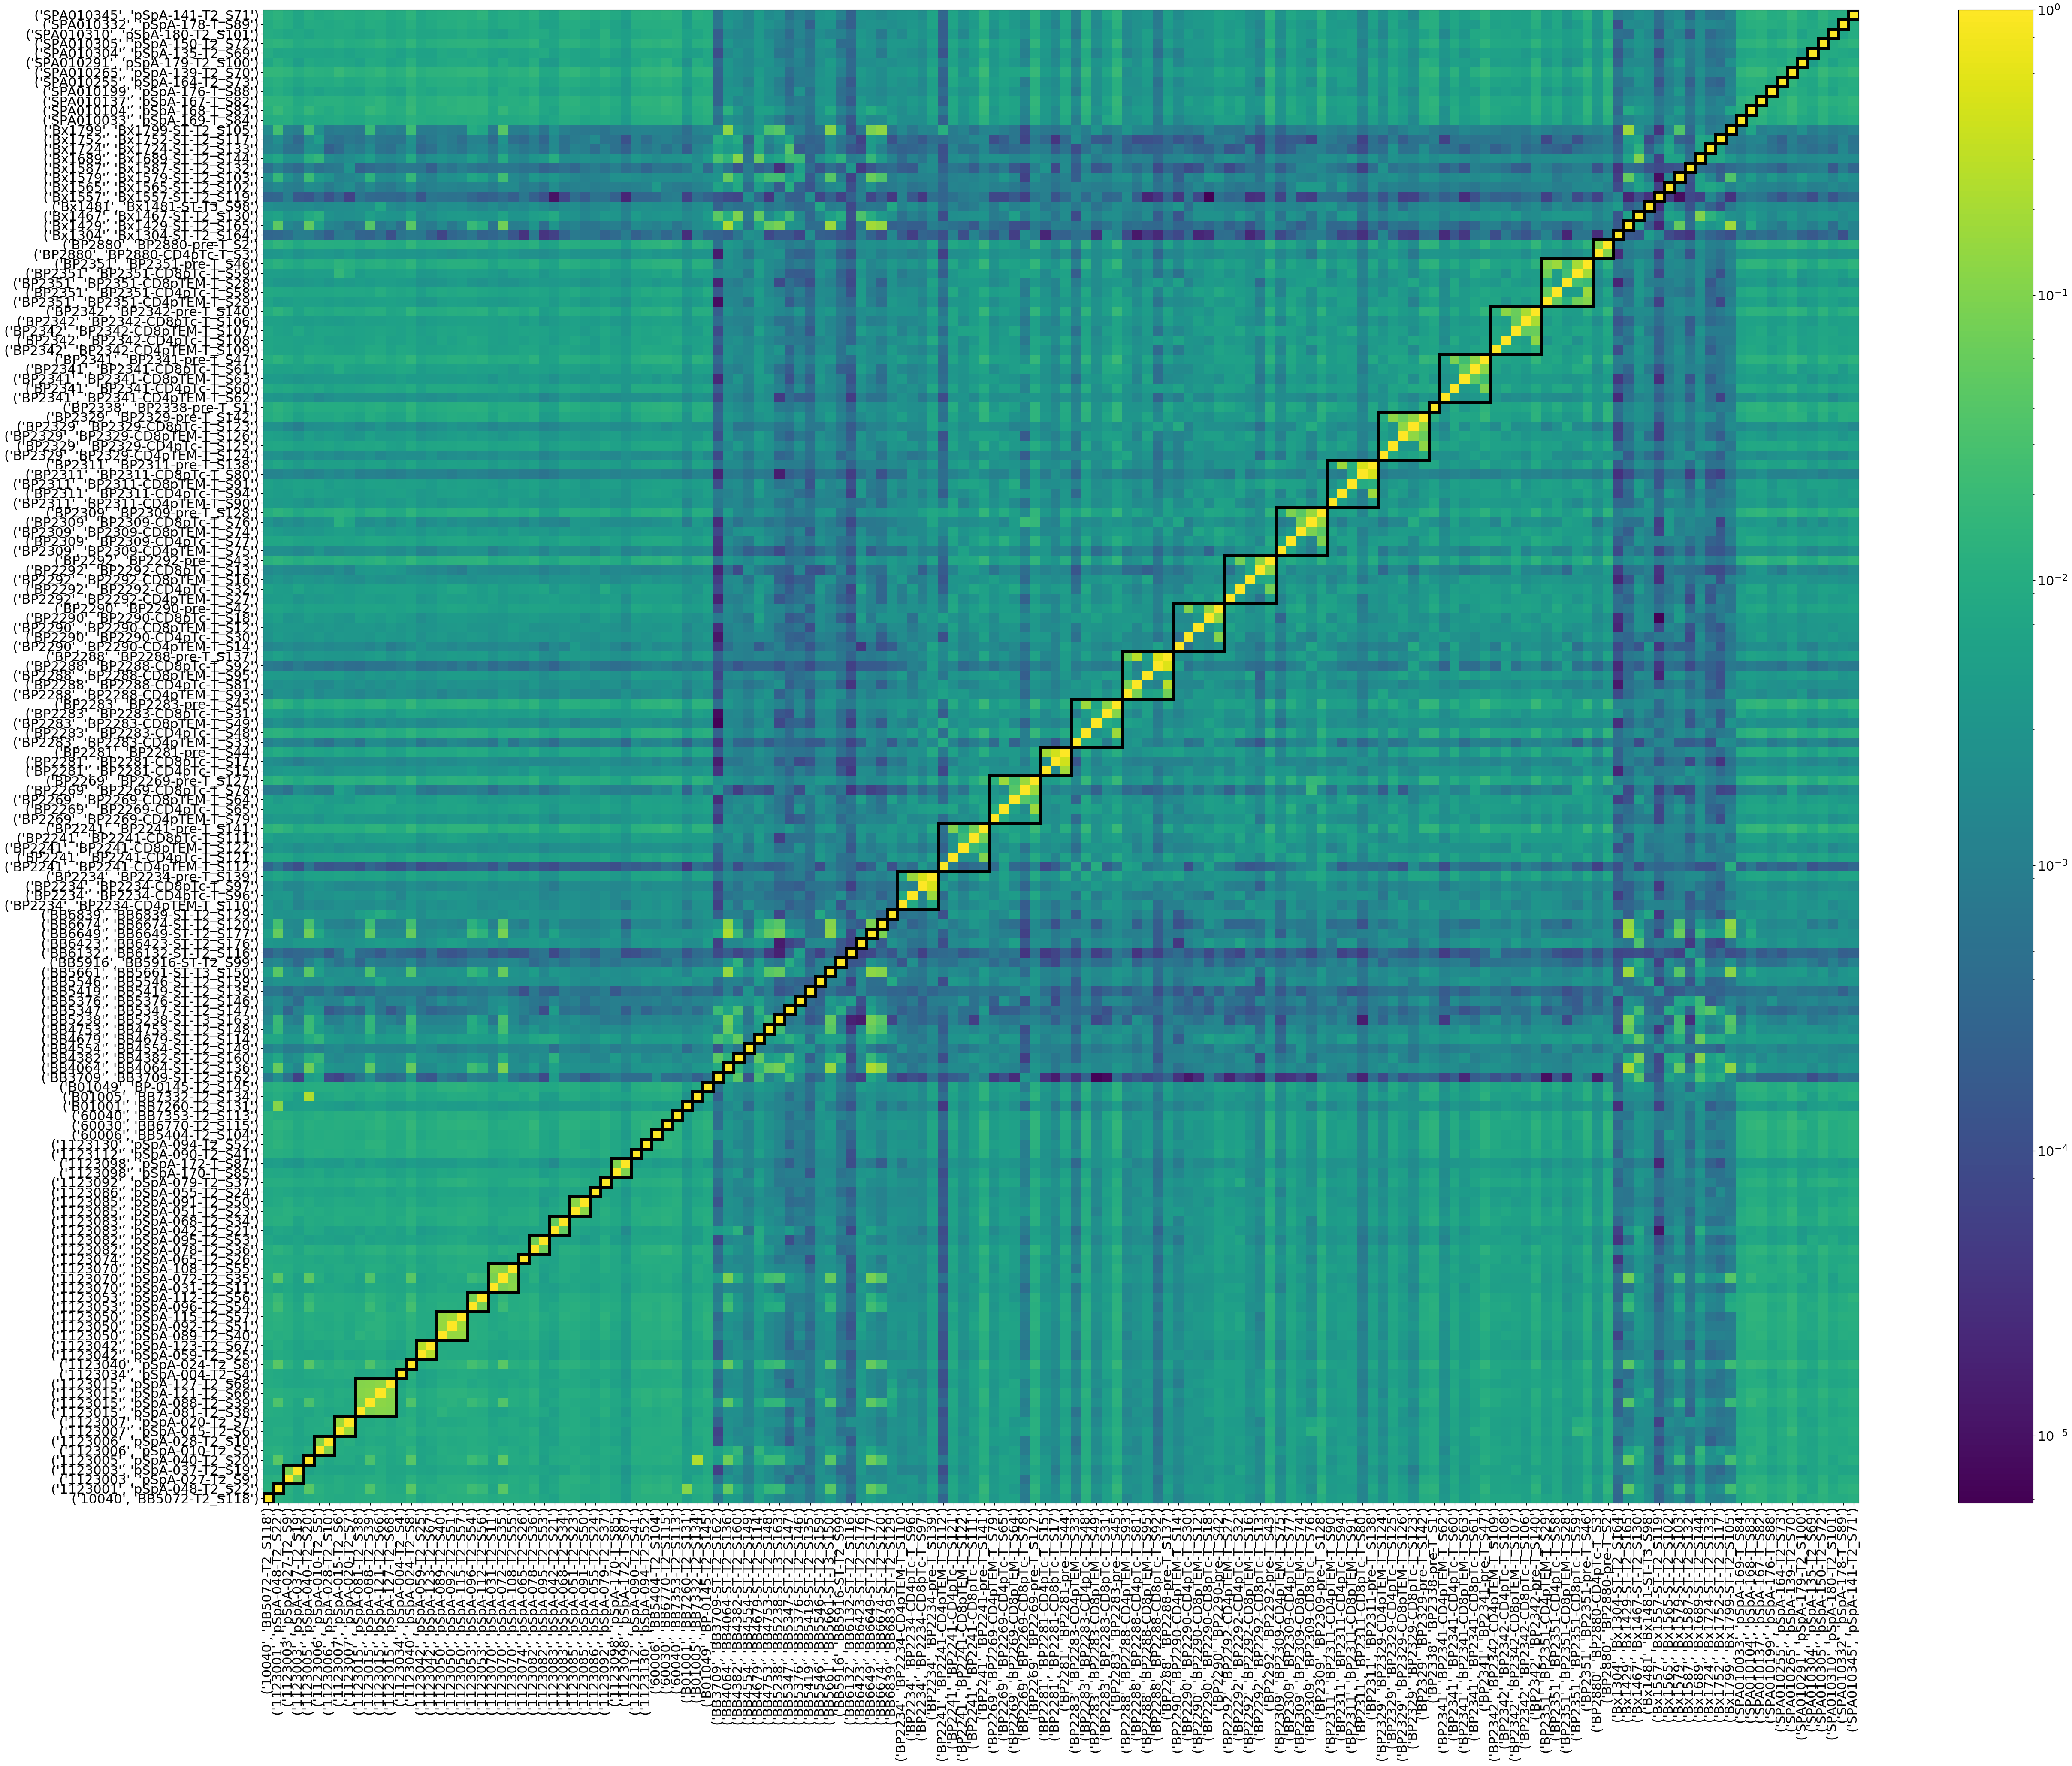

In [17]:
drawHeatmap(sim)

## Highlight anomalies

In [18]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [19]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.06288647309574236 0.09406153565287599
mean diff patient 0.004686365948305588 0.007780249576166203
threshold 0.0358073642529704


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

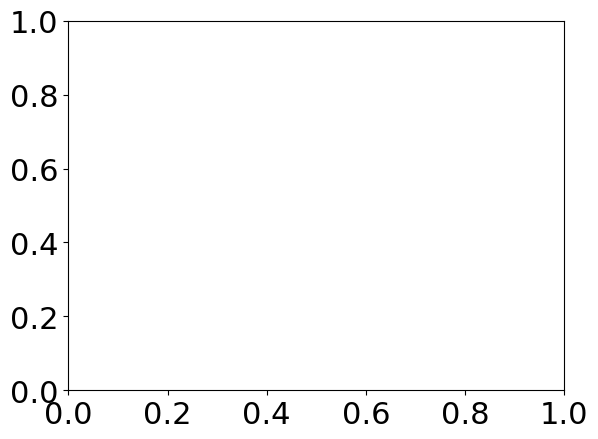

In [20]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

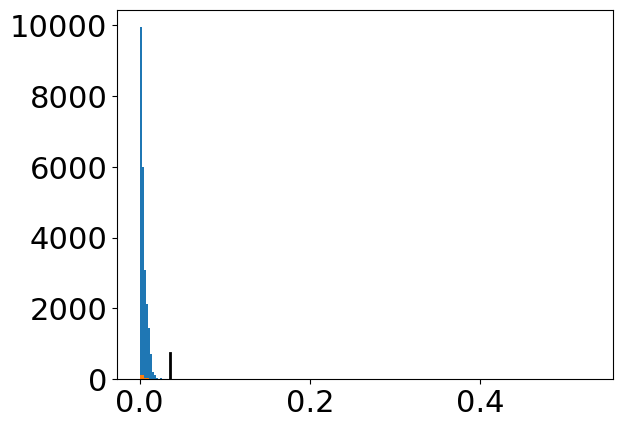

In [21]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [22]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('1123001', 'pSpA-048-T2_S22') ('1123005', 'pSpA-040-T2_S20') 0.04269824606928441
('1123001', 'pSpA-048-T2_S22') ('1123040', 'pSpA-024-T2_S8') 0.042944116548483624
('1123001', 'pSpA-048-T2_S22') ('1123070', 'pSpA-072-T2_S35') 0.043527478833712
('1123001', 'pSpA-048-T2_S22') ('B01001', 'BB7260-T2_S131') 0.11178356721932092
('1123001', 'pSpA-048-T2_S22') ('BB4064', 'BB4064-ST-T2_S136') 0.05906628040403206
('1123001', 'pSpA-048-T2_S22') ('BB5661', 'BB5661-ST-T3_S150') 0.042782424517495476
('1123001', 'pSpA-048-T2_S22') ('BB6649', 'BB6649-ST-T2_S177') 0.057336045837387384
('1123001', 'pSpA-048-T2_S22') ('Bx1429', 'Bx1429-ST-T2_S165') 0.048800738788962184
('1123005', 'pSpA-040-T2_S20') ('1123001', 'pSpA-048-T2_S22') 0.04269824606928441
('1123005', 'pSpA-040-T2_S20') ('1123040', 'pSpA-024-T2_S8') 0.042451035571332896
('1123005', 'pSpA-040-T2_S20') ('1123070', 'pSpA-072-T2_S35') 0.047315829219976124
('1123005', 'pSpA-040-T2_S20') ('B01005', 'BB7332-T2_S134') 0.2407794567296887
('1123005', 'pS

In [23]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

In [ ]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)

min value: 5.812094969637194e-06
max value: 1.0
